In [1]:
import zipfile
import requests
import pandas as pd
import numpy as np
from io import BytesIO

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


In [2]:
# ============================================================
# 1) DOWNLOAD DATASET ZIP (OFFICIAL SOURCE)
# ============================================================

zip_url = "https://data.openei.org/files/6458/correlated_outage_readme.zip"

headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(zip_url, headers=headers, timeout=120)
resp.raise_for_status()

zip_bytes = BytesIO(resp.content)

print("ZIP downloaded successfully.")

ZIP downloaded successfully.


In [3]:
# ============================================================
# 2) INSPECT ZIP + AUTO-SELECT A RELEVANT CSV
# ============================================================

with zipfile.ZipFile(zip_bytes) as z:
    all_files = z.namelist()

print("\nTotal files in ZIP:", len(all_files))
print("First 20 files:")
for name in all_files[:20]:
    print(" -", name)


Total files in ZIP: 32
First 20 files:
 - correlated_outage/
 - correlated_outage/eaglei_outages_2014_agg.csv
 - correlated_outage/eaglei_outages_2014_merged.csv
 - correlated_outage/eaglei_outages_2015_agg.csv
 - correlated_outage/eaglei_outages_2015_merged.csv
 - correlated_outage/eaglei_outages_2016_agg.csv
 - correlated_outage/eaglei_outages_2016_merged.csv
 - correlated_outage/eaglei_outages_2017_agg.csv
 - correlated_outage/eaglei_outages_2017_merged.csv
 - correlated_outage/eaglei_outages_2018_agg.csv
 - correlated_outage/eaglei_outages_2018_merged.csv
 - correlated_outage/eaglei_outages_2019_agg.csv
 - correlated_outage/eaglei_outages_2019_merged.csv
 - correlated_outage/eaglei_outages_2020_agg.csv
 - correlated_outage/eaglei_outages_2020_merged.csv
 - correlated_outage/eaglei_outages_2021_agg.csv
 - correlated_outage/eaglei_outages_2021_merged.csv
 - correlated_outage/eaglei_outages_2022_agg.csv
 - correlated_outage/eaglei_outages_2022_merged.csv
 - correlated_outage/eaglei_o

In [4]:
# Filter only CSV files
csv_files = [f for f in all_files if f.lower().endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV files found inside the ZIP.")


In [6]:
# Prefer “correlated/event/merged/outage” style CSVs
preferred_keywords = ["correlat", "event", "merged", "outage"]

chosen_csv = None
for kw in preferred_keywords:
    matches = [f for f in csv_files if kw in f.lower()]
    if matches:
        chosen_csv = matches[0]
        break

In [7]:
# Fallback to first CSV
if chosen_csv is None:
    chosen_csv = csv_files[0]

print("\nChosen CSV:", chosen_csv)



Chosen CSV: correlated_outage/eaglei_outages_2014_agg.csv


In [8]:
# ============================================================
# 3) LOAD THE SELECTED CSV INTO A DATAFRAME
# ============================================================

with zipfile.ZipFile(zip_bytes) as z:
    with z.open(chosen_csv) as f:
        df_raw = pd.read_csv(f)

df = df_raw.copy()

print("\nLoaded dataset shape:", df.shape)
print("Columns:")
print(df.columns.tolist())



Loaded dataset shape: (598, 6)
Columns:
['state', 'year', 'month', 'outage_count', 'max_outage_duration', 'customer_weighted_hours']


In [9]:
# ============================================================
# 4) CREATE TARGET: OUTAGE DURATION (MINUTES)
#    - Use existing duration column if present, OR
#    - Compute from start/end timestamps
# ============================================================

def find_column(candidate_names, columns):
    """
    Finds a matching column using:
    (1) exact match (case-insensitive)
    (2) partial match (candidate substring in column name)
    """
    cols_lower = {c.lower(): c for c in columns}

    # Exact match first
    for cand in candidate_names:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]

    # Partial match next
    for cand in candidate_names:
        for c in columns:
            if cand.lower() in c.lower():
                return c

    return None


In [11]:
# Try to locate a duration column, else start/end time columns
duration_col = find_column(
    ["duration", "outage_duration", "duration_minutes", "duration_min"],
    df.columns
)

start_col = find_column(
    ["start_time", "event_start", "outage_start", "start_datetime", "start"],
    df.columns
)

end_col = find_column(
    ["end_time", "event_end", "outage_end", "end_datetime", "end"],
    df.columns
)

if duration_col is not None:
    # Use duration directly (converted to numeric)
    df["target_duration_min"] = pd.to_numeric(df[duration_col], errors="coerce")
    print(f"\nTarget created from existing duration column: {duration_col}")

elif start_col is not None and end_col is not None:
    # Compute duration from timestamps
    df[start_col] = pd.to_datetime(df[start_col], errors="coerce")
    df[end_col] = pd.to_datetime(df[end_col], errors="coerce")

    df["target_duration_min"] = (df[end_col] - df[start_col]).dt.total_seconds() / 60.0
    print(f"\nTarget computed from timestamps: {start_col} -> {end_col}")

else:
    raise ValueError(
        "Could not find a duration column or start/end timestamps to compute duration.\n"
        "Please review printed columns and update the mapping logic if needed."
    )


Target created from existing duration column: max_outage_duration


In [12]:
# Clean invalid targets
df = df[df["target_duration_min"].notna()]
df = df[df["target_duration_min"] >= 0]

print("\nTarget duration summary:")
print(df["target_duration_min"].describe())



Target duration summary:
count    598.000000
mean       6.075669
std       18.320077
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max      139.500000
Name: target_duration_min, dtype: float64


In [13]:
# ============================================================
# 5) FEATURE SELECTION
#    - Keep numeric features
#    - Add low-cardinality categorical features (<= 50 unique values)
# ============================================================

target = "target_duration_min"


In [14]:
# Numeric columns (exclude target)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

In [15]:
# Find candidate categorical columns by keywords (common in outage/event datasets)
cat_keywords = ["state", "cause", "event_type", "incident_type", "region", "event", "incident"]

candidate_cat_cols = [
    c for c in df.columns
    if any(k in c.lower() for k in cat_keywords)
]


In [16]:
# Keep only low-cardinality object categorical columns
categorical_cols = []
for c in candidate_cat_cols:
    if df[c].dtype == "object":
        nunique = df[c].nunique(dropna=True)
        if nunique <= 50:
            categorical_cols.append(c)

feature_cols = numeric_cols + categorical_cols

print("\nSelected numeric features:", len(numeric_cols))
print("Selected categorical features:", len(categorical_cols))
print("Total features selected:", len(feature_cols))

X = df[feature_cols].copy()
y = df[target].copy()

print("\nFinal X shape:", X.shape)
print("Final y shape:", y.shape)



Selected numeric features: 5
Selected categorical features: 1
Total features selected: 6

Final X shape: (598, 6)
Final y shape: (598,)


In [17]:
# ============================================================
# 6) TRAIN/TEST SPLIT (80/20)
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [18]:
# ============================================================
# 7) MODELING: PREPROCESSING + RANDOM FOREST REGRESSION
#    - Numeric: StandardScaler
#    - Categorical: OneHotEncoder (handle_unknown='ignore')
# ============================================================

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder="drop"
)

rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

pipeline = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", rf_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['year', 'month',
                                                   'outage_count',
                                                   'max_outage_duration',
                                                   'customer_weighted_hours']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['state'])])),
                ('model',
                 RandomForestRegressor(n_estimators=200, n_jobs=-1,
                                       random_state=42))])

In [19]:
# ============================================================
# 8) EVALUATION
#    Metrics: MAE, RMSE, R^2
# ============================================================

y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nModel Performance on Test Set")
print(f"MAE  : {mae:.2f} minutes")
print(f"RMSE : {rmse:.2f} minutes")
print(f"R^2  : {r2:.3f}")


Model Performance on Test Set
MAE  : 0.27 minutes
RMSE : 1.37 minutes
R^2  : 0.993


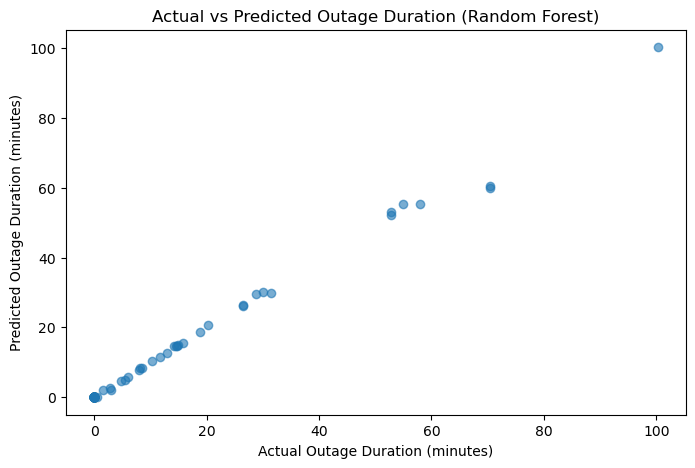

In [20]:

# ============================================================
# 9) VISUALIZATION: ACTUAL vs PREDICTED
# ============================================================

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Outage Duration (minutes)")
plt.ylabel("Predicted Outage Duration (minutes)")
plt.title("Actual vs Predicted Outage Duration (Random Forest)")
plt.show()